In [1]:
#Marsha Gomez Gomez
#MIRCV 2021
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [9]:

import numpy as np


BASE_PATH = '/content/gdrive/My Drive/CIDL-PROJECT/numpy data/'
out_path = BASE_PATH + 'out'
train_path = BASE_PATH+'public_test_tensor.npy'
train_labels = BASE_PATH+'public_test_labels.npy'

def load_training():
  #images = np.load(os.path.join(out_path,train_path))
  images = np.load(train_path)

  #labels = np.load(os.path.join(out_path,train_labels))
  labels = np.load(train_labels)

  return images,labels
 
images, labels= load_training()
print(labels.shape)
print(images.shape)


(672,)
(672, 150, 150)


In [ ]:
#To support GPU
!pip install opencv-python==4.4.0.46

     |████████████████████████████████| 49.5MB 86kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30


In [ ]:
import cv2
import os
import glob

import numpy as np

from PIL import Image
from IPython.display import clear_output, display
from imutils.video import VideoStream, FileVideoStream
from tqdm.notebook import tqdm
from sklearn.neighbors import NearestCentroid


BASE_DIR = '/content/gdrive/My Drive/mircv2021/data/facerecognition'

#Detector parameters
DET_PROTO = BASE_DIR + '/caffe/face_detector/deploy.prototxt'
DET_MODEL = BASE_DIR + '/caffe/face_detector/res10_300x300_ssd_iter_140000_fp16.caffemodel'
DET_LAYER = 'detection_out'
DET_SIZE = (300, 300)
DET_MEAN = (123, 177,104)
DET_THRESHOLD = 0.7

#VGG2 parameters
FEAT_PROTO = BASE_DIR + '/caffe/face_features/resnet50_ft.prototxt'
FEAT_MODEL = BASE_DIR + '/caffe/face_features/resnet50_ft.caffemodel'
FEAT_LAYER = "pool5/7x7_s1"
FEAT_SIZE = (224, 224)
FEAT_MEAN = (91.4953, 103.8827, 131.0912)
PRED_THRESHOLD = 0.7

SRC_FOLDER = BASE_DIR + '/classes'

#k-Nearest Neighbors
VIDEO_PATH = BASE_DIR +  "/videos/dimartedi.mp4"
FRAMES_TO_SKIP = 800

GREEN = (0, 255, 0)
RED = (0, 0, 255)

print("Variables Done")

Variables Done


In [ ]:
def highlight(img, rect, color, text=None):
    #cv2.rectangle(img, rect[0], rect[1], color, 3, 3, 0)
    cv2.rectangle(img, rect[0], rect[1], color, 3)

    point = (rect[0][0] - 20, rect[1][1] + 50)
    if text != None:
        cv2.putText(img, text, point, 4, 1.2, color)


def getImageROI(img, face):
    return img[face[0][1]:face[1][1], face[0][0]:face[1][0]]


def display_img(img, is_bgr=True):
  if is_bgr:  # convert color from CV2 BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)    
  display(Image.fromarray(img))
  clear_output(wait=True)


print("Done Functions")

Done Functions


In [ ]:
class DNNExtractor:    
    
    def __init__(self, net_proto_path, trained_model_path, size, mean_values=None):
        self.size = size
        self.mean_values = mean_values

        self.net = cv2.dnn.readNetFromCaffe(net_proto_path, trained_model_path)
        # to enable GPU (this won't work on Colab without recompiling opencv)
        self.net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
        self.net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)
        
    
    def extract(self, img, layer, normalize=False):
        blob = cv2.dnn.blobFromImage(img, 1.0, self.size, self.mean_values, swapRB=False, crop=False)
        self.net.setInput(blob)
        prob = self.net.forward(layer).flatten()

        if normalize:
            prob /= np.linalg.norm(prob)

        return prob
    
# it creates an instance of the class DNNExtractor
det = DNNExtractor(DET_PROTO, DET_MODEL, DET_SIZE, DET_MEAN)
fe = DNNExtractor(FEAT_PROTO, FEAT_MODEL, FEAT_SIZE, FEAT_MEAN)

print("Done DNN")

Done DNN


In [ ]:
def extract_features(img_folder):
    # find all jpgs inside a subfolder
    img_paths = glob.glob(SRC_FOLDER + "/*/*.jpg")
    img_paths = sorted(img_paths)

    # get the id from filename: 22301.lavia.jpg --> lavia
    ids = [os.path.basename(path).split('.')[1] for path in img_paths]

    # extract features
    descs = [fe.extract(cv2.imread(path), FEAT_LAYER, normalize=True) for path in tqdm(img_paths)]

    return np.array(descs), np.array(ids)

descs, ids = extract_features(SRC_FOLDER)

print("Extract Features Done")


Extract Features Done


In [ ]:
#TODO: STEP 1 - Detection

#detection is a vector of values
#please note that the detection coordinates are normalized. Revert back to the original coordinate system before putting them on the faces
#[batchId, classId, confidence, left, top, right, bottom]
def detect(img):
  bbs = det.extract(img, DET_LAYER)
  bbs = bbs.reshape(-1, 7)  # one detection per row
  h,w, _ = img.shape
    
  faces = []

  for batch_id, class_id, confidence, left, top, right, bottom in bbs:
    #check if the confidence value <  DET_THRESHOLD
    if confidence > DET_THRESHOLD:
      left_n = np.int32(left*w)
      top_n = np.int32(top*h)
      right_n = np.int32(right*w)
      bottom_n = np.int32(bottom*h)
      #determine points p0 and p1, i.e. the top left and bottom right vertex of the BB, with respect to the original coordinates from the normalized dimensions: left, top, right, bottom 
      faces.append([batch_id, class_id, confidence, left_n , top_n, right_n, bottom_n])
  return faces
print("Done detect")


Done detect


faces


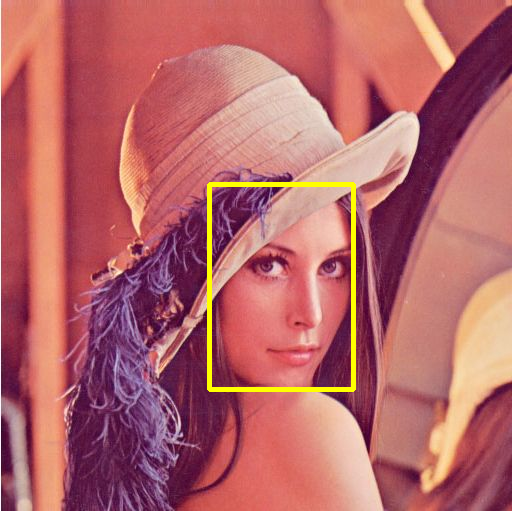

In [ ]:
#TODO: STEP 2 - Bounding Boxes
img = cv2.imread(os.path.join(BASE_DIR, 'lenna.jpg'))
faces = detect(img)
print("faces")

#for each face use highlight function to draw the face BB
for batch_id, class_id, confidence, left, top, right, bottom in faces:
  rect = [(left, top), (right, bottom)]
  highlight(img, rect, (0,255,255))

#call display_img to display the detected faces
display_img(img)

In [ ]:
#TODO: STEP 3 - 1NN Classifier

class OneNNClassifier:
    
  def __init__(self, ids, descs):
      self.ids = ids
      self.descs = descs

  def predict(self, queryF):
    #evaluate the dot products between descs and queryF
    dots = np.dot(self.descs, queryF)

    #To sort the results create a zip between dot products and ids
    zipped = zip(dots, self.ids)

    #then call the sorted function to sort them
    results = sorted(zipped, reverse = True)

    #return just the first result of the results list
    return results

print("Done Class")

Done Class


In [ ]:
classifier = OneNNClassifier(ids, descs)

In [ ]:
#TODO: STEP 4 - Video face detection & recognition

def play_video(video_path, classifier):
  frame_count = 0

  print("[INFO] starting " + video_path)

  #vs = VideoStream(src=0).start() #webcam
  vs = FileVideoStream(video_path).start()

  # loop over frames from the video file stream
  while vs.more():

      # grab the frame from the threaded video stream
      frame = vs.read()

      if frame_count % FRAMES_TO_SKIP == 0:
          bb_color = GREEN
          detected_faces = detect(frame)
          #foreach detected face
          for detected_face in detected_faces:
            print(detected_face)
            # [batch_id, class_id, confidence, left_n , top_n, right_n, bottom_n]

            #get the image ROI
            rect = [(detected_face[3], detected_face[4]), (detected_face[5], detected_face[6])]

            img_roi = getImageROI(frame, rect)

            #extract face features
            description = fe.extract(img_roi, FEAT_LAYER, normalize=True)
            print(description)
            
            #classify
            res = classifier.predict(description)
            
            print(res[0][1])
            print("RESULTATO")
            print(res)
            
            #highlight the detected face
            if res[0][0] < PRED_THRESHOLD:
              highlight(frame, rect, RED, "UNKNOWN")
            else:
              highlight(frame, rect, bb_color, res[0][1])

          display_img(frame)
          
      frame_count += 1

print("Done play_video")

Done play_video


[0.0, 1.0, 0.9999056, 151, 88, 258, 310]
[0.0164181  0.00421026 0.02266032 ... 0.00775793 0.00424675 0.03202223]
salvini
RESULTATO
[(0.94221365, 'salvini'), (0.9369905, 'salvini'), (0.93092096, 'salvini'), (0.91035414, 'salvini'), (0.88073206, 'salvini'), (0.8662358, 'salvini'), (0.8652705, 'salvini'), (0.863867, 'salvini'), (0.8588614, 'salvini'), (0.8537039, 'salvini'), (0.8460818, 'salvini'), (0.8436315, 'salvini'), (0.8368021, 'salvini'), (0.8286377, 'salvini'), (0.82621837, 'salvini'), (0.8176197, 'salvini'), (0.814481, 'salvini'), (0.80068827, 'salvini'), (0.7991961, 'salvini'), (0.794781, 'salvini'), (0.4729792, 'giannini'), (0.4653373, 'giannini'), (0.43097588, 'giannini'), (0.42997456, 'giannini'), (0.42920366, 'giannini'), (0.4224534, 'giannini'), (0.41409588, 'giannini'), (0.41398227, 'giannini'), (0.41368705, 'giannini'), (0.40059546, 'lavia'), (0.3989816, 'giannini'), (0.39897633, 'lavia'), (0.39710492, 'lavia'), (0.39549926, 'lavia'), (0.3942956, 'lavia'), (0.38640565, 'l

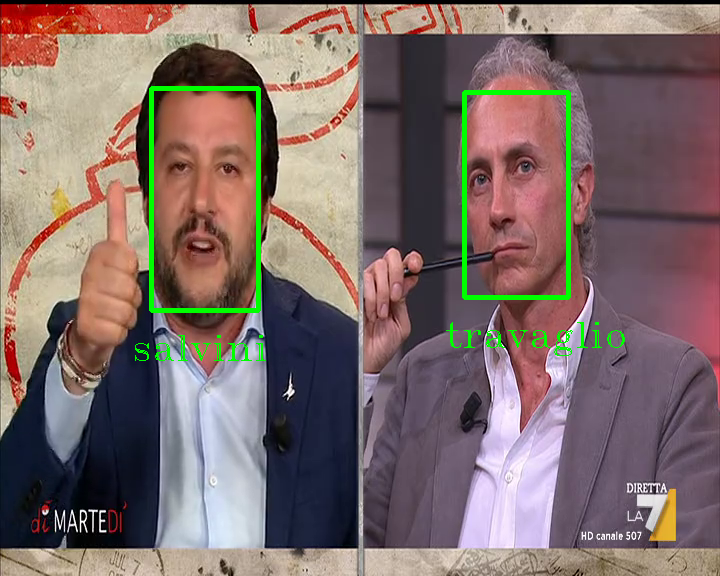

In [ ]:
play_video(VIDEO_PATH, classifier)

In [ ]:
#TODO: STEP 5 -  Nearest centroid classifier


#Review Code with Nearest Centroid Classification
  # mean_descs = np.array(descs)
  # mean_ids = np.array(ids)
  # centroid = NearestCentroid()
  # centroid.fit(mean_descs, mean_ids)

#evaluate the mean feature for each class
  # centroid.score(mean_descs, mean_ids)

  # centroid.predict(descs)
#set the class ids

#init OneNNClassifier to make use of mean features

## QUA DOVREBBE ESSERE IL INIT OneNNClassifier

#TODO: STEP 5 -  Nearest centroid classifier
mean_descs = {}
mean_ids = []

#evaluate the mean feature for each class
desIds = zip(descs, ids)
for id in ids:
  mean_descs[id] = []

for des, id in desIds:
  mean_descs[id].append(des)

mean_descs2 = []
for id, Ldescs in mean_descs.items():
  mean_ids.append(id)
  mean_descs2.append(np.average(Ldescs, axis=0))
  #print(res)

#set the class ids

#init OneNNClassifier to make use of mean features
nearest_centroid_classifier = OneNNClassifier(mean_ids, mean_descs2)



In [ ]:
nearest_centroid_classifier = OneNNClassifier(mean_ids, mean_descs)

[0.0, 1.0, 0.9999056, 151, 88, 258, 310]
[0.0164181  0.00421026 0.02266032 ... 0.00775793 0.00424675 0.03202223]
salvini
RESULTATO
[(0.94221365, 'salvini'), (0.9369905, 'salvini'), (0.93092096, 'salvini'), (0.91035414, 'salvini'), (0.88073206, 'salvini'), (0.8662358, 'salvini'), (0.8652705, 'salvini'), (0.863867, 'salvini'), (0.8588614, 'salvini'), (0.8537039, 'salvini'), (0.8460818, 'salvini'), (0.8436315, 'salvini'), (0.8368021, 'salvini'), (0.8286377, 'salvini'), (0.82621837, 'salvini'), (0.8176197, 'salvini'), (0.814481, 'salvini'), (0.80068827, 'salvini'), (0.7991961, 'salvini'), (0.794781, 'salvini'), (0.4729792, 'giannini'), (0.4653373, 'giannini'), (0.43097588, 'giannini'), (0.42997456, 'giannini'), (0.42920366, 'giannini'), (0.4224534, 'giannini'), (0.41409588, 'giannini'), (0.41398227, 'giannini'), (0.41368705, 'giannini'), (0.40059546, 'lavia'), (0.3989816, 'giannini'), (0.39897633, 'lavia'), (0.39710492, 'lavia'), (0.39549926, 'lavia'), (0.3942956, 'lavia'), (0.38640565, 'l

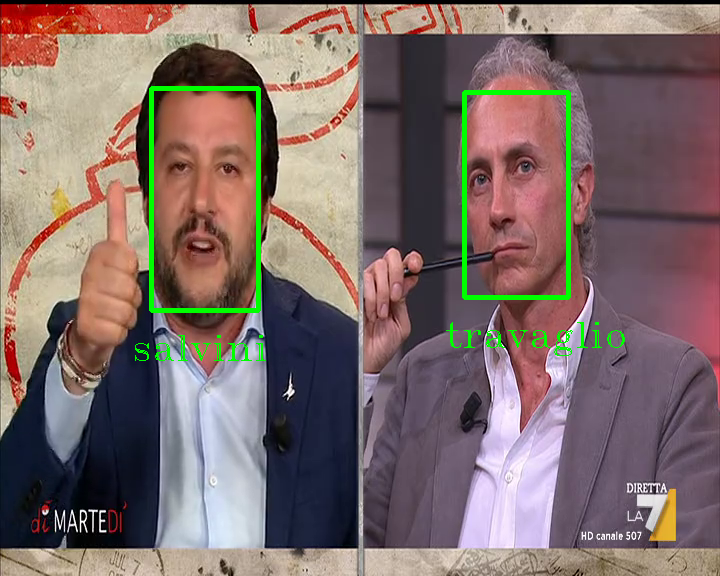

In [ ]:
play_video(VIDEO_PATH, nearest_centroid_classifier)